# German License Plate Recognition - Model Training and Evaluation
    
In this project, you will be tasked with building a plagiarism detector that examines a text file and performs binary classification; labeling that file as either plagiarized or not, depending on how similar the text file is when compared to a provided source text.
    
    
The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with this data, and knowing what kinds of features you have to work with as you transform and group the data!

So, this notebook is all about exploring the data and noting patterns about the features you are given and the distribution of data.

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import tensorflow as tf
import zipfile
import matplotlib

from distutils.version import StrictVersion
from imutils import paths
from PIL import Image

In [3]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('2.2.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v2.2.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('3.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v2.2.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 2.2.0-dev20200317
GPU device: /device:GPU:0


In [4]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index])
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

In [6]:
from config.license_recognition import config

# datasets
GLP_HDF5 = 'data/license_recognition/background.h5'
BACKGRND_HDF5 = 'data/license_recognition/glp.h5'

# image size <=> network input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

# training parameter
DOWNSAMPLE_FACTOR = config.DOWNSAMPLE_FACTOR
MAX_TEXT_LEN = config.MAX_TEXT_LEN

BATCH_SIZE = 64
NUM_EPOCHS = 1000

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = 'adagrad'

OUTPUT_PATH = 'output/license_recognition'
DOCUMENTATION_PATH = 'documentation'
MODEL_NAME = 'glpr-model'

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = 'data/license_recognition/test_images'

# create model output directory
os.makedirs(os.path.join(OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("GLP Dataset:        {}".format(GLP_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs (max):       {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Test Images Path:   {}".format(TEST_IMAGES))

GLP Dataset:        data/license_recognition/background.h5
Background Dataset: data/license_recognition/glp.h5
Batch Size:         64
Epochs (max):       1000
Image Size:         (128, 64)
Optimizer:          adagrad
Model Name:         glpr-model
Output Path:        output/license_recognition
Model Weights Path: output/license_recognition\adagrad\glpr-model-weights.h5
Model Path:         output/license_recognition\adagrad\glpr-model.h5
Documentation Path: documentation
Test Images Path:   data/license_recognition/test_images


# License Plate Dataset

In [7]:
from license_plate_image_augmentor import LicensePlateImageAugmentor
from utils.io import Hdf5DatasetLoader

In [8]:
loader = Hdf5DatasetLoader()
background_images = loader.load(GLP_HDF5, shuffle=True, max_items=10000)
images, labels = loader.load(BACKGRND_HDF5, shuffle=True, max_items=25)

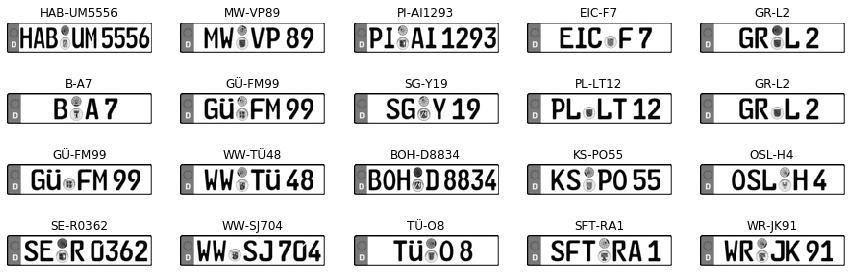

In [9]:
show_images(images[4:], labels[4:])

In [10]:
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)

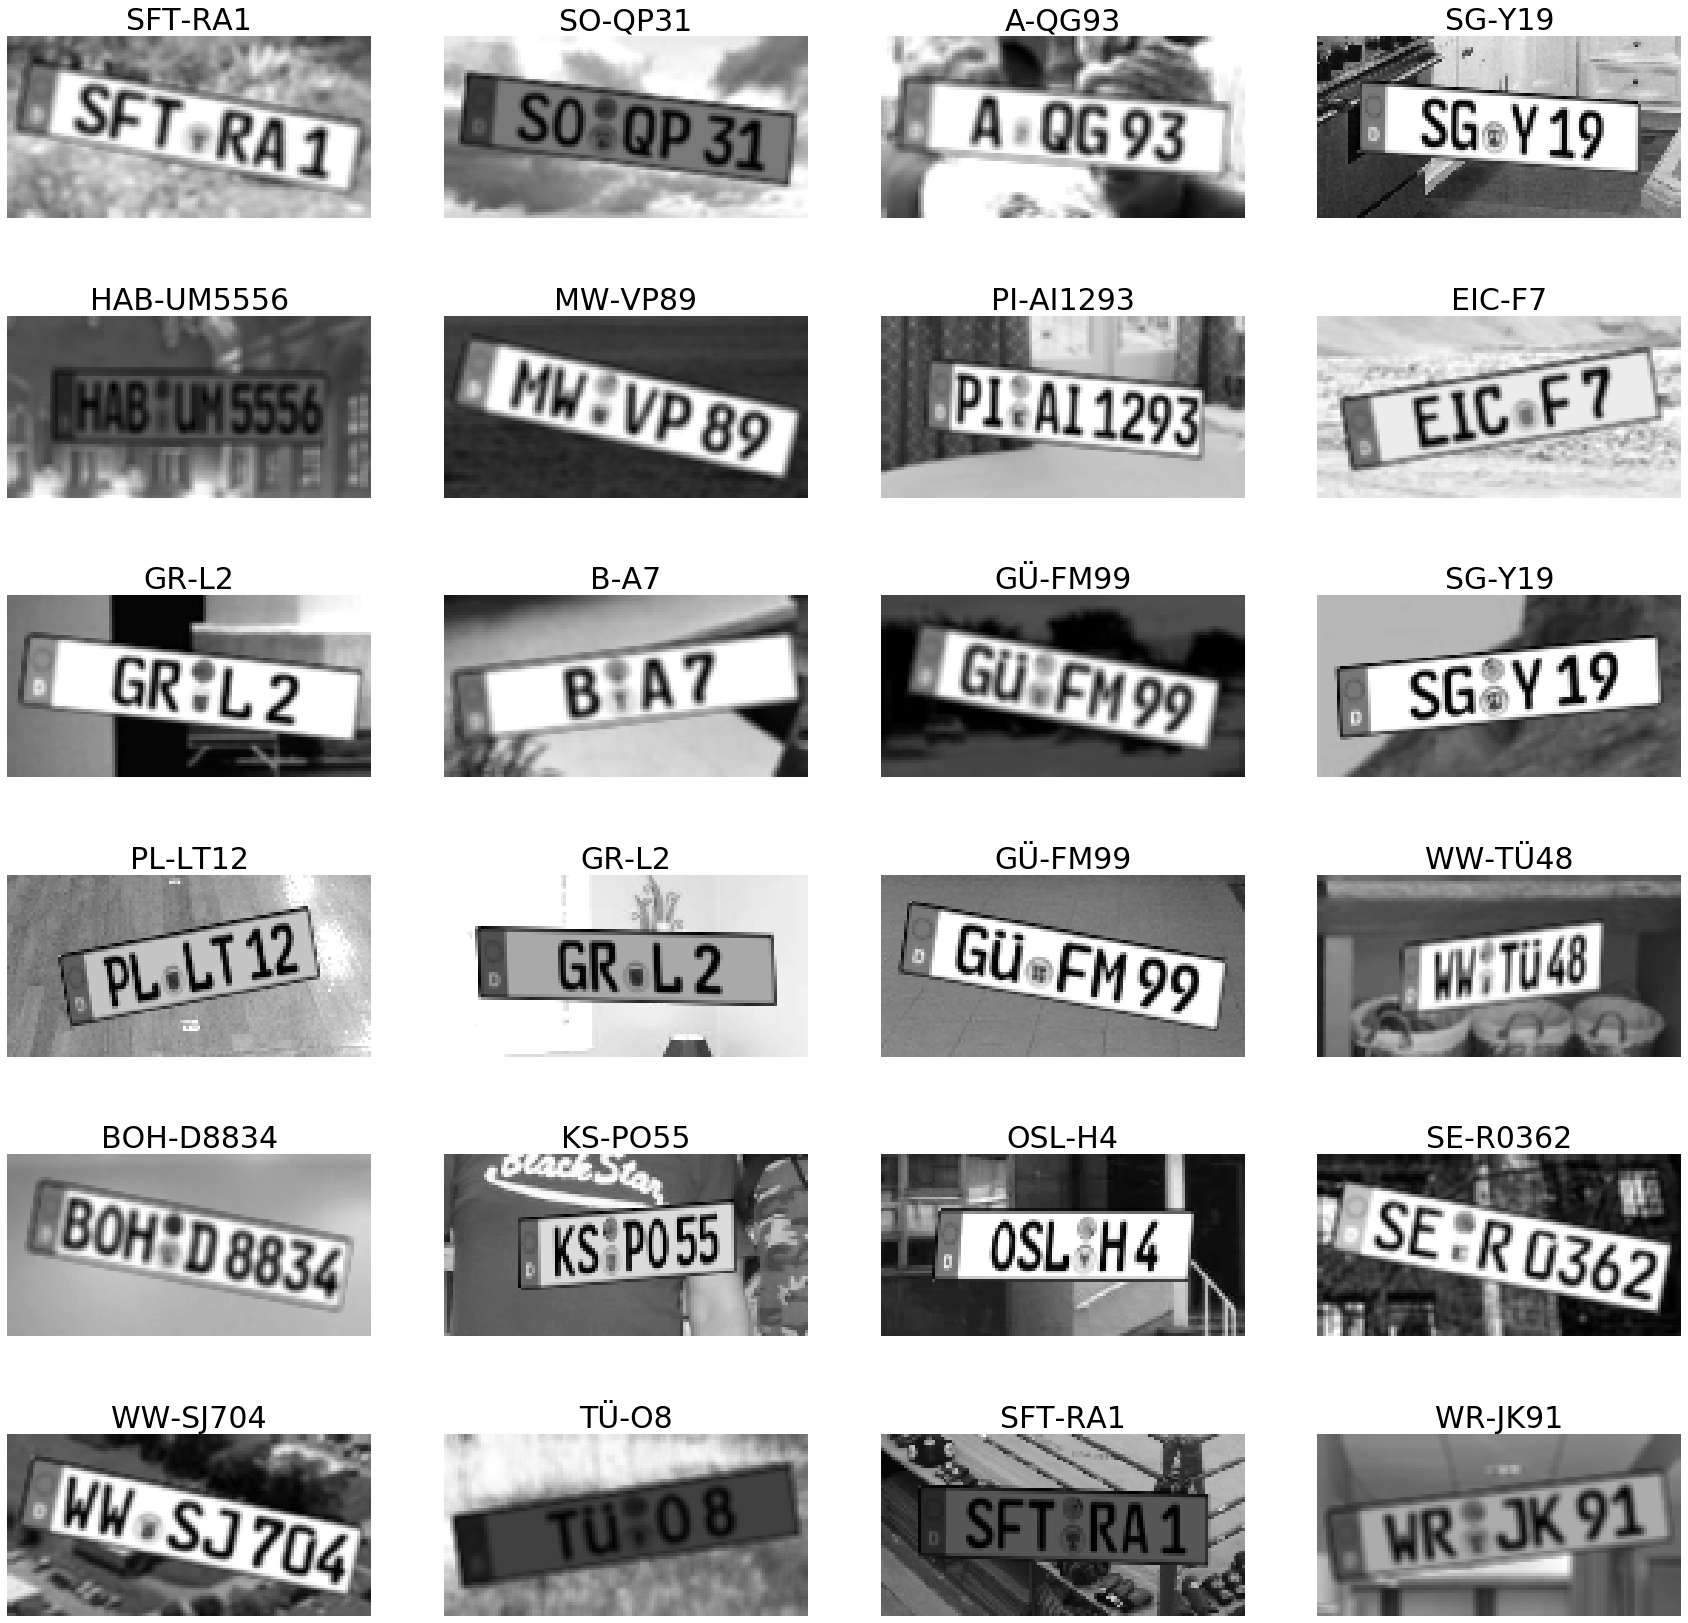

In [11]:
cols = 4
rows = len(images) // cols

image_index = 0
fig, axarr = plt.subplots(rows, cols, figsize=(30, 30))
for r in range(rows):
    for c in range(cols):
        image = images[image_index]
        image = augmentor.generate_plate_image(image)
        axarr[r, c].axis("off")
        axarr[r, c].title.set_size(30)
        axarr[r, c].title.set_text(labels[image_index])
        axarr[r, c].imshow(image, cmap='gray')
        image_index += 1

plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train dataset size:      {}".format(X_train.shape[0]))
print("Validation dataset size: {}".format(X_val.shape[0]))
print("Test dataset size:       {}".format(X_test.shape[0]))

Train dataset size:      16
Validation dataset size: 4
Test dataset size:       5


In [13]:
from licence_plate_dataset_generator import LicensePlateDatasetGenerator

train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                               augmentor)

val_generator = LicensePlateDatasetGenerator(X_val, y_val, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                             augmentor)

test_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                              DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                              augmentor)

C:\Users\Andreas\Anaconda3\envs\mlnd\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


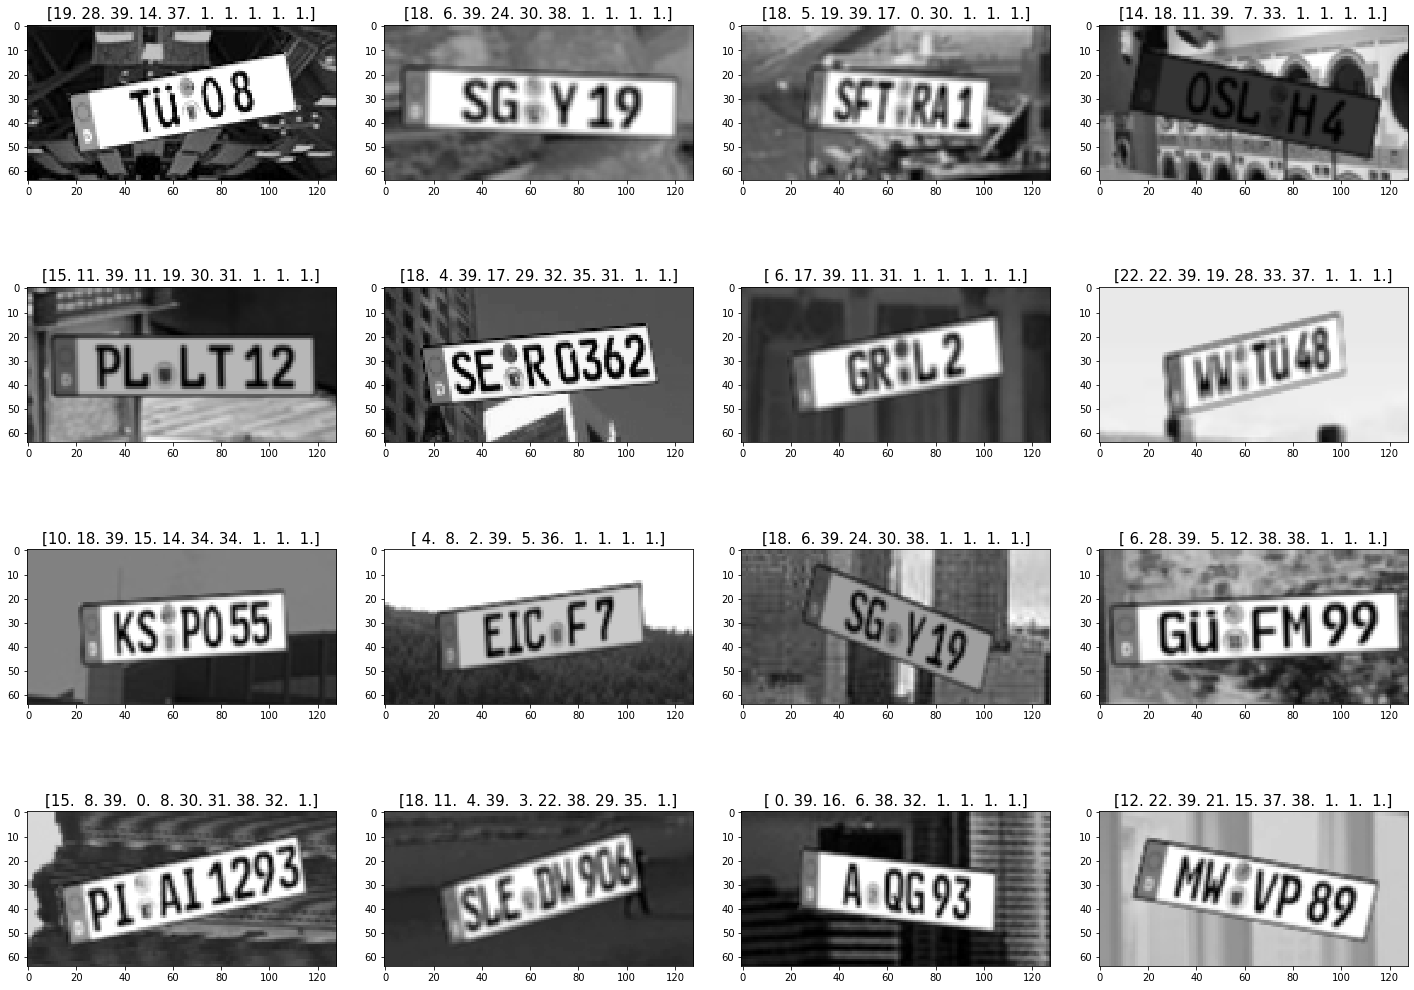

In [14]:
inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,15))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(config.IMAGE_HEIGHT, config.IMAGE_WIDTH)
        ax.title.set_size(15)
        ax.title.set_text(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(16 / 4), 4)

In [21]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from utils.nn.conv import OCR
from label_codec import LabelCodec
from train_helper import TrainHelper
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        return tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(config.MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((config.IMAGE_WIDTH, config.IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=TrainHelper.get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 32, 16)        64  

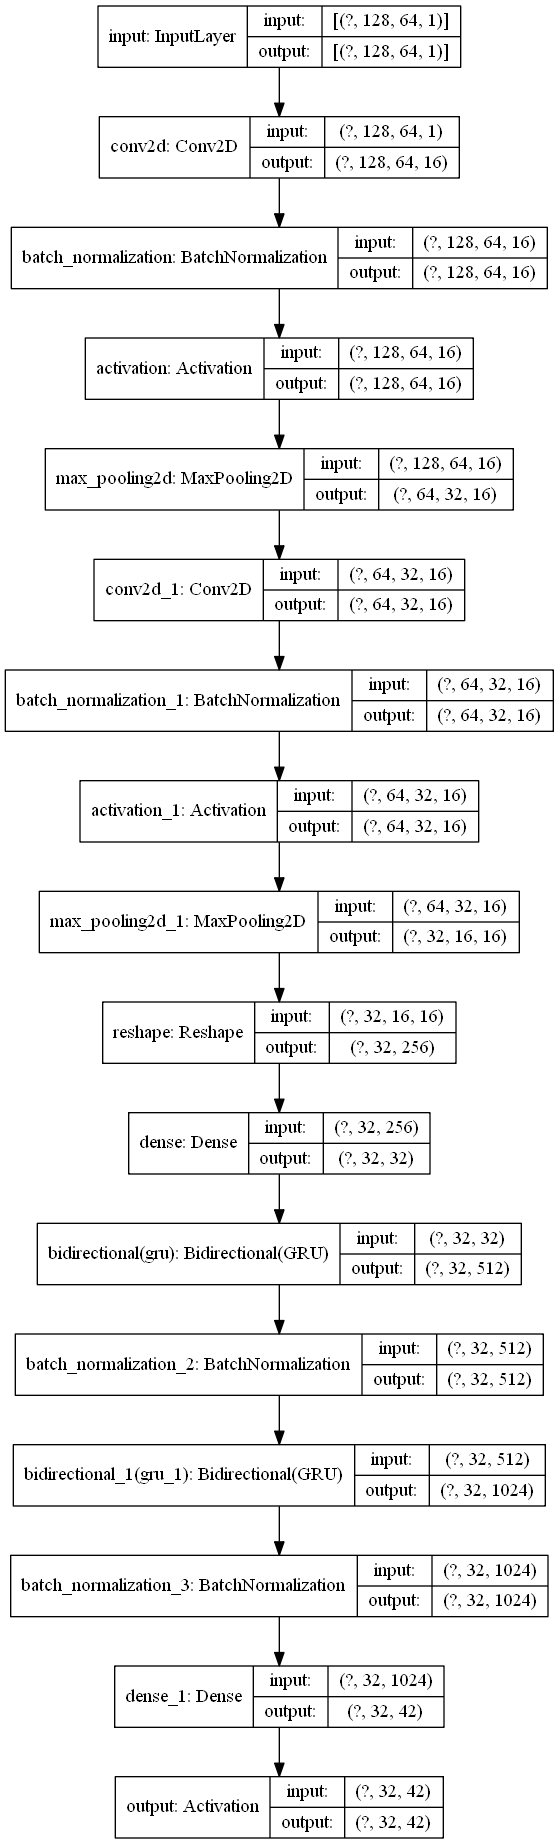

In [22]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file, width=400)

In [ ]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=TrainHelper.get_callbacks(OPTIMIZER, MODEL_WEIGHTS_PATH), verbose=1)

In [ ]:
from tensorflow.keras.models import save_model

predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-train-history-" + OPTIMIZER + ".png")
plt.show()

In [ ]:
inputs = next(test_generator.generator())
score = train_model.evaluate(inputs, verbose=0)
print('Test loss: {0:.4f}'.format(score))

In [ ]:
predict_model.save(os.path.join(OUTPUT_PATH, OPTIMIZER, "saved_model"), save_format='tf')

Convert to TFLite Model

In [ ]:
from tensorflow_core.lite.python.lite import TFLiteConverter, Optimize

converter = TFLiteConverter.from_keras_model_file(MODEL_PATH)
converter.optimizations.append(Optimize.DEFAULT)
converter.target_spec.supported_types.append(tf.float16)
converter.experimental_new_converter = True
tflite_model = converter.convert()

open(TFLITE_MODEL_PATH, "wb").write(tflite_model)

# Predict

In [80]:
def show_image(image):
    plt.axis("off")
    plt.title(label)
    plt.imshow(image, cmap='gray')
    plt.show()

In [82]:
from tensorflow.keras.models import load_model

tf.compat.v1.disable_eager_execution()
model = load_model(MODEL_PATH, compile=False)

In [19]:
from PIL import Image
from utils.preprocessing import AspectAwarePreprocessor

preprocessor = AspectAwarePreprocessor(IMAGE_WIDTH, IMAGE_HEIGHT)

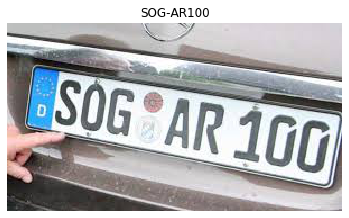

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_6/Conv2D}}]]
	 [[output_3/truediv/_919]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_6/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

In [89]:
from label_codec import LabelCodec

img_filename = random.choice(os.listdir(TEST_IMAGES))
img_filepath = os.path.join(TEST_IMAGES, img_filename)
label = img_filename.split(".")[0].split("#")[0]

image = Image.open(img_filepath) 

# original image
show_image(image)

# predict
image = p.preprocess(image)
image = image.astype(np.float32) / 255.

image = np.expand_dims(image.T, axis=-1)

predictions = model.predict(np.asarray([image]))
pred_number = LabelCodec.decode_prediction(predictions[0])

fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(1, 2, wspace=.5, hspace=0.1)
ax1 = plt.Subplot(fig, outer[0])
fig.add_subplot(ax1)
print('Predicted: %9s\nTrue:      %9s\n=> %s' % (pred_number, label, pred_number == label))
image = image[:, :, 0].T
ax1.set_title('True: {}\nPred: {}'.format(label, pred_number), loc='left')
ax1.imshow(image, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.Subplot(fig, outer[1])
fig.add_subplot(ax2)
ax2.set_title('Activations')
ax2.imshow(predictions[0].T, cmap='binary', interpolation='nearest')
ax2.set_yticks(list(range(len(LabelCodec.ALPHABET) + 1)))
ax2.set_yticklabels(LabelCodec.ALPHABET)  # + ['blank'])
ax2.grid(False)
for h in np.arange(-0.5, len(LabelCodec.ALPHABET) + 1 + 0.5, 1):
    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)